# Exercises: HPC

### π in parallel

Let's compute the value of π=3.1415926.... in parallel using Monte Carlo simulations.

Below is a function that does this by throwing darts inside a box of $[-1, 1]^2$. It follows from the definition of π that the area fo a circle is $A = \pi r^2$, where $r$ is the radius of a circle. We develop a Monte Carlo algorithm to compute π by randomly throwing darts (i.e., generating uniformly distributed random numbers inside a unit box) and counting the fraction of the points that land inside the circle.

Let's try to visualize the setup first. 

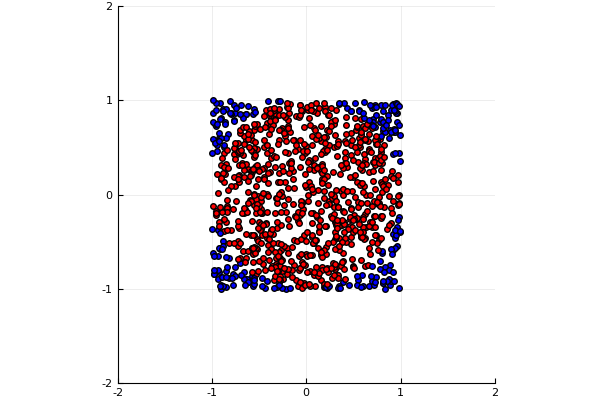

In [60]:
using Plots
pyplot()

plt = plot( xlims=(-2,2), ylims=(-2,2), aspect_ratio=1)
for n in 1:1000
    x = rand()*2 - 1
    y = rand()*2 - 1
    
    r = sqrt(x^2 + y^2)
    if r < 1
        #inside
        scatter!([x], [y], color="red", label="")
    else
        #outside
        scatter!([x], [y], color="blue",label="")
    end
end
plt #display plot

Can you see the circle? Now, let's do some actual computing.

In [45]:
function compute_pi(N::Int)
    n_landed_in_circle = 0  # counts number of points that have radial coordinate < 1, i.e. in circle
    for i = 1:N
        x = rand() * 2 - 1  # uniformly distributed number on x-axis
        y = rand() * 2 - 1  # uniformly distributed number on y-axis

        r = sqrt(x*x + y*y)  # radius squared, in radial coordinates
        if r < 1
            n_landed_in_circle += 1
        end
    end

    return n_landed_in_circle / N * 4.0    
end


compute_pi (generic function with 1 method)

In [59]:
@time compute_pi(10^9) #my very own π!

 10.447697 seconds (6 allocations: 192 bytes)


3.141655268

#### Actual exercise
Your mission? Parallellize the `compute_pi` function! 

Hint: see the `for` loop? Remember `@parallel`? Remember that when using `@parallel` the result of each iteration is taken as the value of the last expression inside the loop. Therefore if your loops ends in
```julia
for 
    #blaablaa
    #...
    if something
        1
    else
        0
    end
end
```
it will result in returning either `1` or `0`.

You can also try adapting this to use `pmap` if you like. 

In [63]:
function compute_parallel_pi(N::Int)
    n_landed_in_circle = 0
    
    n_landed_in_circle = @parallel (+) for i = 1:N
        x = rand() * 2 - 1  # uniformly distributed number on x-axis
        y = rand() * 2 - 1  # uniformly distributed number on y-axis

        r = sqrt(x*x + y*y)  # radius squared, in radial coordinates
        if r < 1
            1 #return +1 to the counts
        else
            0 #return 0 to the counts
        end
        
        # Alternatively, remember the ternary operator? This works just the same:
        #r < 1 ? 1 : 0
    end
    
    return n_landed_in_circle / N * 4
end
  

compute_parallel_pi (generic function with 1 method)

Let's add workers before we run our sweet new function.

In [54]:
addprocs(4)
nprocs()

5

In [64]:
@time compute_parallel_pi(10^9) #my very own fast π!

  1.514820 seconds (10.31 k allocations: 545.058 KiB)


3.14154676

Finally, after you are done, see the full story at [Parallel Monte Carlo in Julia](http://corysimon.github.io/articles/parallel-monte-carlo-in-julia/)

### Advanced: Distributed Arrays

Install `DistributedArrays` as
```julia
Pkg.add("DistributedArrays")
```

then try them out as
```julia
addprocs(4) #adding 4 workers to share the load
@everywhere using DistributedArrays #loading DAs for every worker
A = fill(1.1, (100, 100) ) #create array
DA = distribute(A) #distribute it to workers
sum(DA)
```

### Advanced: MPI

Install `MPI` package by running:
```julia
Pkg.update()
Pkg.add("MPI")
```
In case of problems, see the [readme](https://github.com/JuliaParallel/MPI.jl)

Because of how MPI works, we need to explicitly write our code into a file. Create `01-hello.jl` and `01-hello-impl.jl` as follows:

`01-hello.jl` should look like this:
```julia

import MPI
include("01-hello-impl.jl")

function main()
    MPI.Init()

    do_hello()

    MPI.Finalize()
end

main()
```
and the actual implementation file `01-hello-impl.jl` like this
```julia

function do_hello()
    comm = MPI.COMM_WORLD
    println("Hello world, I am $(MPI.Comm_rank(comm)) of $(MPI.Comm_size(comm))")
    MPI.Barrier(comm)
end
```


You can execute your code the normal way as
```bash
mpirun -np 3 julia 01-hello.jl
```

See the MPI.jl [examples](https://github.com/JuliaParallel/MPI.jl/tree/master/examples) for more.